In [1]:
import librosa as lb
import soundfile as sd
import random as rd
import numpy as np
import json as js
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from librosa.feature.inverse import mel_to_stft
from librosa import griffinlim
from soundfile import write
from tocotron import Tocotron
from conv_var_ae import VarEncoder
from generators import TextMelGenerator

In [2]:
batch_size = 32
data_path = "c:\\Users\\1\\Desktop\\dev-clean"
generator = TextMelGenerator(data_path=data_path, batch_size=batch_size)

In [3]:
test_gen = next(generator)

In [4]:
max_sum = 0
for sample in test_gen["mel_sp"]:

    curent_sum = np.sum(sample)
    if curent_sum > max_sum:

        need_sample = sample
        max_sum = curent_sum
    

In [5]:
audio = mel_to_stft(need_sample)
audio = griffinlim(audio)

In [6]:
audio_folder = "c:\\Users\\1\\Desktop\\audio_files"
audio_file = os.path.join(audio_folder, "0file.wav")
write(audio_file, data=audio, subtype='PCM_24', samplerate=14000)

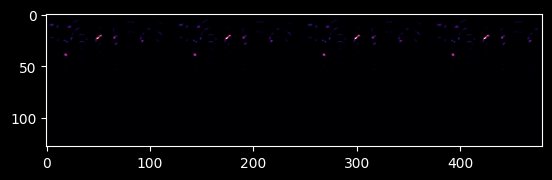

In [7]:
plt.style.use("dark_background")
fig, axis = plt.subplots()
axis.imshow(need_sample, cmap="inferno")
plt.show()

In [8]:
encoder_train_data = []
decoder_train_data = []
need_size = 1000

for (sample_n, sample) in enumerate(iter(generator)):

    if sample_n * batch_size > need_size:
        break

    encoder_train_data.append(sample["text"])
    decoder_train_data.append(sample["mel_sp"])



In [9]:
decoder_train_data = np.concatenate(decoder_train_data, axis=0)
decoder_train_data = decoder_train_data[:, :128, :320]
decoder_train_data = (decoder_train_data - np.mean(decoder_train_data)) / np.std(decoder_train_data)
print(decoder_train_data.shape)


(1024, 128, 320)


In [10]:
tmp_encoder_data = encoder_train_data[0]
for text_sample in encoder_train_data[2:]:
    tmp_encoder_data += text_sample

encoder_train_data = tmp_encoder_data

In [11]:
need_len = max([len(text_sample.split()) for text_sample in encoder_train_data])
for (sample_n, text_sample) in enumerate(encoder_train_data):

    if need_len < len(text_sample.split()):
        prep_text_sample = text_sample[:need_len]
    
    elif need_len > len(text_sample.split()):
        
        add_list  = ["." for _ in range(len(text_sample) - need_len)]
        prep_text_sample = text_sample.split() + add_list
        prep_text_sample = " ".join(word for word in prep_text_sample)
    
    
    encoder_train_data[sample_n] = prep_text_sample

In [12]:
encoder_tokenizer = Tokenizer()
encoder_tokenizer.fit_on_texts(encoder_train_data)
encoder_train_data = encoder_tokenizer.texts_to_sequences(encoder_train_data)
max_len = max([len(text_sample) for text_sample in encoder_train_data])

In [13]:
for (sample_n, token_sample) in enumerate(encoder_train_data):

    if max_len > len(token_sample):

        add_list = [0 for _ in range(max_len - len(token_sample))]
        tmp_tokens = token_sample + add_list
        encoder_train_data[sample_n] = tmp_tokens

In [14]:
encoder_train_data = np.asarray(encoder_train_data, dtype="int")

In [15]:
params_json = {
    "run_folder": "c:\\Users\\1\\Desktop\\models_save\\Tacotron2",
    "encoder_params": {        
        "total_words_n":    len(encoder_tokenizer.word_index) + 1,
        "embedding_size":   100,
        "layers_n":         3,
        "units":            decoder_train_data.shape[2],
        "activation":       None,
        "dropout_rate":    0.34
    },

    "decoder_params": {
        "mel_record_len": decoder_train_data.shape[1],

        "linear_projection": {
            "activation": "linear",
            "dropout_rate": 0.56,
            "epsilon": 0.001
        },

        "prenet_params": {
            "epsilon": 0.001,
            "dropout_rate": 0.56
        },
        
        "filters":          [32, 32, 64, decoder_train_data.shape[2]    ],
        "kernel_size":      [5, 5, 5, 5                                 ],
        "padding":          ["same", "same", "same", "same"             ],
        "strides":          [1, 1, 1, 1                                 ],
        "dropout_rates":    [0.56, 0.56, 0.56, 0.66                     ],
        "activations":      ["tanh", "tanh", "tanh", "tanh"             ],
        "normalization_epsilon": 0.01
    }
}

In [16]:
tocotron_model = Tocotron(params_json=params_json)

In [17]:
print(tocotron_model.encoder.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 100)      │       390,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 320)      │       538,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 320)      │       820,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 320)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 320)      │       820,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 320)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,570,440 (9.81 MB)

 Trainable params: 2,570,440 (9.81 MB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
print(tocotron_model.decoder.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 320) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 320) │        640 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, None, 320) │    820,480 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None, 320) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 320) │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 320)       │    820,480 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 32)  │     51,232 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 320)  │    103,360 │ lstm_4[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 352) │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 32)  │     56,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None, 32)  │         64 │ conv1d_1[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 32)  │      5,152 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None, 32)  │         64 │ conv1d_2[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 64)  │     10,304 │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None, 64)  │        128 │ conv1d_3[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 320) │    102,720 │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None, 320) │        640 │ conv1d_4[0][0]    │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,971,616 (7.52 MB)

 Trainable params: 1,971,616 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
encoder_out = tocotron_model.encoder.predict(encoder_train_data)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


In [20]:
print(encoder_out.shape, decoder_train_data.shape)

(992, 70, 320) (1024, 128, 320)


In [21]:
decoder_train_data = decoder_train_data[:encoder_out.shape[0]]
decoder_out = tocotron_model.decoder.predict([decoder_train_data, encoder_out])

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step


In [22]:
model_output = tocotron_model.model.predict([encoder_train_data, decoder_train_data])

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step


In [23]:
#tocotron_model.train(encoder_train_data, decoder_train_data, epochs=10, batch_size=32, shuffle=True)

In [24]:
# random_sample = decoder_preds[np.random.randint(0, 100)]
# fig, axis = plt.subplots()
# axis.imshow(random_sample, cmap="inferno")
# plt.show()

In [25]:
# samplrate=14000
# audio = mel_to_stft(random_sample)
# audio = griffinlim(audio)

In [26]:
# audio_folder = "c:\\Users\\1\\Desktop\\audio_files"
# audio_file = os.path.join(audio_folder, "0file.wav")
# write(audio_file, data=audio, subtype='PCM_24', samplerate=samplrate)

In [27]:
var_encoder_params = {
    "input_shape": decoder_train_data.shape[1:] + (1, ),
    "hiden_dim": 2,
    "encoder_out_activations": "tanh",
    "encoder_conv_filters":         [32, 32, 64, 64                         ],
    "encoder_conv_kernel_size":     [3, 3, 3, 3                             ],
    "encoder_conv_strides":         [1, 2, 2, 1                             ],
    "encoder_conv_padding":         ["same", "same", "same", "same"         ],
    "encoder_conv_activations":     ["linear", "linear", "linear", "linear" ],
    "encoder_conv_dropout":         [0.56, 0.56, 0.56, 0.56                 ],
    "encoder_dense_units":          [32, 32, 64, 64                         ],
    "encoder_dense_dropout_rates":  [0.56, 0.56, 0.56, 0.56                 ],
    "encoder_dense_activations":    ["linear", "linear", "linear", "linear" ],
    "decoder_conv_filters":         [32, 32, 64, 64                         ],
    "decoder_conv_kernel_size":     [3, 3, 3, 3                             ],
    "decoder_conv_strides":         [1, 2, 2, 1                             ],
    "decoder_conv_padding":         ["same", "same", "same", "same"         ],
    "decoder_conv_activations":     ["linear", "linear", "linear", "linear" ],
    "decoder_conv_dropout":         [0.56, 0.56, 0.56, 0.56                 ],
    "decoder_out_activations": "tanh",
    "weights_init": {
        "mean": 0.81,
        "stddev": 1.1
    }
}

In [28]:
conv_var_ae = VarEncoder(params_json=var_encoder_params)

In [29]:
conv_var_ae.encoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 320,  │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 320,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 320,  │          0 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 320,  │        128 │ dropout_9[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 160,   │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 160,   │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 160,   │          0 │ activation_5[0][… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 160,   │        128 │ dropout_10[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 80,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 32, 80,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 80,    │          0 │ activation_6[0][… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 80,    │        256 │ dropout_11[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 80,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 32, 80,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 80,    │          0 │ activation_7[0][… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 80,    │        256 │ dropout_12[0][0]

 Total params: 5,316,260 (20.28 MB)

 Trainable params: 5,315,876 (20.28 MB)

 Non-trainable params: 384 (1.50 KB)

In [30]:
conv_var_ae.decoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 163840)         │       491,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 80, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 160, 32)    │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64, 160, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64, 160, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 160, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 320, 64)   │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 320, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 320, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 320, 1)    │           577 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128, 320, 1)    │             

 Total params: 576,001 (2.20 MB)

 Trainable params: 575,617 (2.20 MB)

 Non-trainable params: 384 (1.50 KB)

In [31]:
#conv_var_ae.train(train_tensor=decoder_train_data, train_labels=decoder_train_data, epochs=20, batch_size=32, epoch_per_save=10, 
#                  run_folder="c:\\Users\\1\\Desktop\\mel_generation_test")

In [32]:
# encoder_preds = conv_var_ae.encoder.predict(decoder_train_data)
# decoder_preds = conv_var_ae.decoder.predict(encoder_preds)

In [33]:
# decoder_preds = np.squeeze(decoder_preds, axis=3)

In [34]:
# random_sample = decoder_preds[np.random.randint(0, 100)]
# plt.style.use("dark_background")
# fig, axis = plt.subplots()
# axis.imshow(random_sample, cmap="inferno")
# plt.show()

In [35]:
# audio = mel_to_stft(random_sample)
# audio = griffinlim(audio)

In [36]:
# samplerate = 23000
# audio_folder = "c:\\Users\\1\\Desktop\\audio_files"
# audio_file = os.path.join(audio_folder, "0file.wav")
# write(audio_file, data=audio, subtype='PCM_24', samplerate=samplerate)

In [274]:
test_model_json = {

    # "encoder_block": {
    #     "LayerType": "conv1d",
    #     "params": {
    #         "weights_init": {
    #             "init_type": "random_normal",
    #             "params": {
    #                 "mean": 12.1,
    #                 "stddev": 34.98
    #             }
    #         },
    #         "filters": [32, 64, 128, 128, 128],
    #         "kernel_sizes": [5, 5, 5, 5, 5],
    #         "strides": [1, 1, 1, 1, 1],
    #         "activations": ["relu", "relu", "relu", "relu", "relu"],
    #         "paddings": ["same", "same", "same", "same", "same"],
    #     }
    # },
    
    "encoder_block": {

        "lstm_block":{
            "LayerType": "lstm",
            "params": {
                "weights_init": {
                    "init_type": "random_normal",
                    "params": {
                        "mean": 12.1,
                        "stddev": 34.98
                    }
                },
                "units": [32, 128, 256],
                "activations": ["linear", "linear", "linear"],
                "bi": [True, True, True],
                "return_sequences": False
            }
        },

        "linear_block": {
            "LayerType": "linear",
            "params": {
                "weights_init": {
                    "init_type": "random_normal",
                    "params": {
                        "mean": 12.1,
                        "stddev": 34.98
                    }
                },
                "units": [128, 64, 3],
                "activations": ["linear", "linear", "linear"]
            }
        }
    },

    "decoder_block": {
        "conv_block":{
            "LayerType": "conv1d_transpose",
            "params": {
                "filters": [32, 64, 128, 128, 128],
                "kernel_sizes": [5, 5, 5, 5, 5],
                "strides": [1, 1, 1, 1, 1],
                "activations": ["relu", "relu", "relu", "relu", "relu"],
                "paddings": ["same", "same", "same", "same", "same"],
            }
        },
        "linear_block": {
            "LayerType": "lstm",
            "params": {
                "units": [128, 64, 32, 3],
                "activations": ["relu", "linear", "linear", "linear"] 
            }
        }
    }
}

In [222]:
from layers_blocks import LayersBlock
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Flatten, Dense
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, Dropout, LayerNormalization, Reshape
from tensorflow.keras.layers import Conv1DTranspose, Conv2DTranspose, Conv3DTranspose, Add, Concatenate, Multiply
from tensorflow.keras.layers import Activation
from tensorflow.keras.initializers import RandomNormal, RandomUniform, Zeros, HeNormal, he_uniform, ones
from tensorflow.keras import Model, Sequential
from tensorflow import Module

In [223]:
def build_encoder():

    input_layer = Input(shape=(None, ))
    output_layer = LayersBlock(test_model_json["encoder_block"]["lstm_block"])(input_layer)
    
    return output_layer

def build_decoder(saved_shape, encoder_out):

    
    input_one = Input(shape=decoder_train_data.shape[1:])
    input_two = Input(shape=encoder_out.shape[1:])
    
    lstm_layer = 

    

    

In [224]:
input_layer, saved_shape, encoder = build_encoder()
decoder = build_decoder(saved_shape)

(128, 128)


In [225]:
print(encoder.summary())

Model: "functional_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_108 (InputLayer)    │ (None, 128, 320)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_109 (Sequential)     │ (None, 128, 128)       │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_31          │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │        49,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,339 (993.51 KB)

 Trainable params: 254,339 (993.51 KB)

 Non-trainable params: 0 (0.00 B)

None


In [226]:
print(decoder.summary())

Model: "functional_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_110 (InputLayer)    │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16384)          │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_110 (Sequential)     │ (None, 128, 32)        │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_111 (Sequential)     │ (None, 128, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_112 (Sequential)     │ (None, 128, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_113 (Sequential)     │ (None, 128, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_114 (Sequential)     │ (None, 128, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_32          │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 128, 320)       │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_134 (Activation)     │ (None, 128, 320)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,912 (1.93 MB)

 Trainable params: 506,912 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [227]:
model_input = Input(shape=decoder_train_data.shape[1:])
model_output = decoder(encoder(model_input))
model = Model(inputs=model_input, outputs=model_output)
model.compile(loss="mean_squared_error", optimizer="adam")

In [228]:
model.fit(decoder_train_data, decoder_train_data, epochs=100, batch_size=64)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.9939
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 1.0099
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.8535
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.8877
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.9280
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 1.0147
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.9590
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.9516
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.9778
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.9127
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.9951
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.9690
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 1.0452
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.9445
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [229]:
encoded_points = encoder.predict(decoder_train_data)
decoded_mels = decoder.predict(encoded_points)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


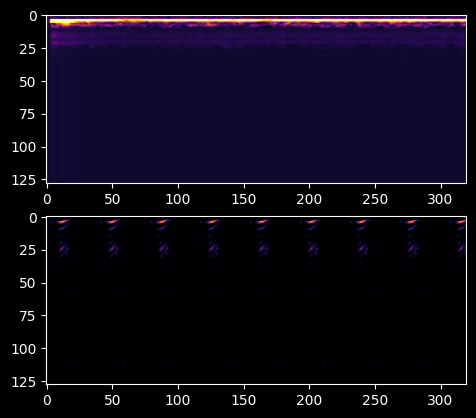

In [271]:
random_idx = np.random.randint(0, 1000)
random_decoded_sample = decoded_mels[random_idx]
random_true_sample = decoder_train_data[random_idx]


plt.style.use("dark_background")
fig, axis = plt.subplots(nrows=2)
axis[0].imshow(random_decoded_sample, cmap="inferno")
axis[1].imshow(random_true_sample, cmap="inferno")
plt.show()

In [272]:
audio = mel_to_stft(random_decoded_sample)
audio = griffinlim(audio)

In [273]:
audio_folder = "c:\\Users\\1\\Desktop\\audio_files"
audio_file = os.path.join(audio_folder, "0file.wav")
write(audio_file, data=audio, subtype='PCM_24', samplerate=20999)